### In this notebook, we apply `popsed` to GAMA photometry catalog.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [2]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [3]:
test_par = torch.Tensor([[.1, 0.1, 0.1, 0.0, 4, -1.3, 1.2, 1.2, 0, 0.02, 8.0],
                         [0.5, 0.5, 0.5, 0.5, 4, -1.3, 1.2, 1.2, 0, 0.3, 10.0]]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(test_par, noise=noise, #SNR=5,
                                           noise_model_dir=noise_model_dir)
mags

tensor([[22.0570, 20.7588, 20.2064, 19.8680, 19.6200],
        [24.7916, 23.5192, 22.3238, 21.8986, 21.5769]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [4]:
### VIKING filters: http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set

#### Load GAMA photometry catalog

In [3]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [4]:
X_data = np.load('./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch.npy')[:, :5]
print('Total number of samples:', len(X_data))

Total number of samples: 110619


In [7]:
from itertools import combinations
from torch.utils.data import DataLoader
import gc

In [8]:
scaler = StandardScaler(device='cpu')
scaler.fit(X_data)
_X_data = scaler.transform(X_data)
# Determine the intrinsic sampling loss
X_datas = []
for i in range(5):
    ind = np.random.randint(0, len(_X_data), 10000)
    X_datas.append(torch.Tensor(_X_data[ind]).to('cuda'))
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.002, 'scaling': 0.9})
intr_loss = []
for i in range(5):
    dataloader = DataLoader(_X_data, batch_size=10000, shuffle=True)
    data_loss = 0.
    for x in dataloader:
        data_loss += L(X_datas[i], x.to('cuda'))
    loss = data_loss / len(dataloader)
    intr_loss.append(loss.item())

print("Intrinsic sampling loss:", np.mean(intr_loss), '+-', np.std(intr_loss))
del X_datas
gc.collect()
torch.cuda.empty_cache()

Intrinsic sampling loss: 0.1534694105386734 +- 0.0007182958587952851


In [9]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [10]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0, 0.8]) # np.array([0.15, 0.35])
_prior_NDE[-1] = np.array([7.5, 13.])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

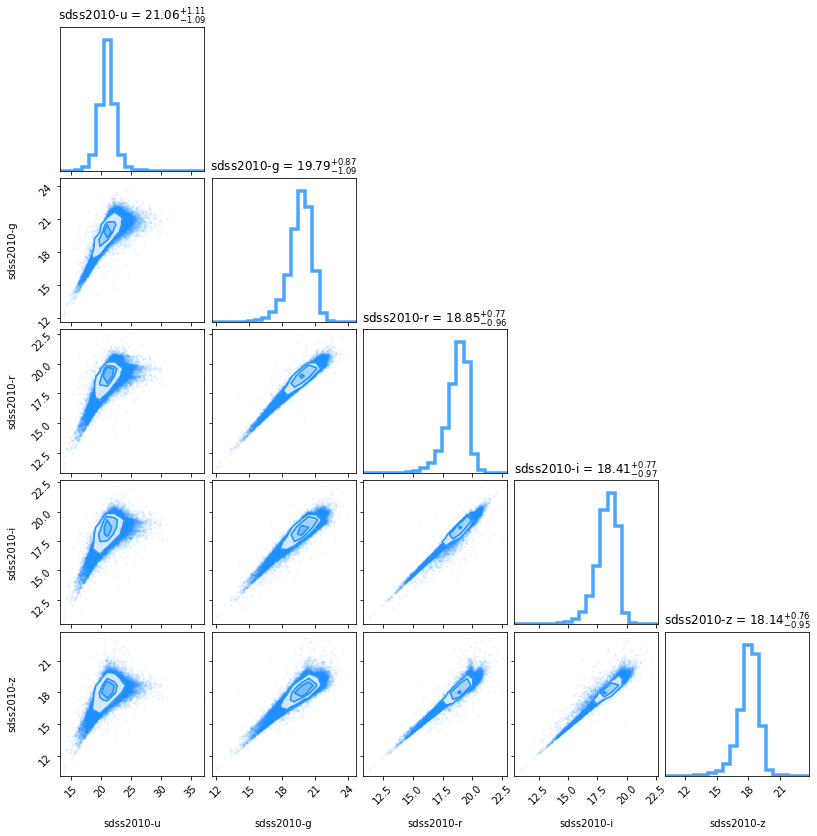

In [11]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data,#.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [12]:
X_train, X_vali = train_test_split(X_data, test_size=0.15)
if name == 'NMF_ZH':
    Y_train = torch.ones(len(X_train), 12)
else:
    Y_train = torch.ones(len(X_train), 11)

### now we provide the redshift distribution to it

In [13]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [15]:
seed = 42
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 10), 
                   np.abs(np.random.normal(size=len(_bounds)) / 10)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=20,  # 10
                                              num_bins=50,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [16]:
NDE_theta.build(
    Y_train,
    X_train,
    filterset=gama_filters,
    z_score=True,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

NDE_theta.external_redshift_data = None

[-0.01362403  0.02232225  0.12269251  0.04213816 -0.01098937 -0.00396168
 -0.14692338  0.06838077  0.06616907  0.08793975 -0.0449231 ]
Total number of params in the model: 2479030


In [17]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

In [18]:
noise = 'gama'
max_epochs = 40
anneal_tau = 12
anneal_coeff = 20
max_lr = 3e-4
NDE_theta.output_dir = "./NDE/GAMA/anneal/real/test/"

blurs = [0.3, 0.3, 0.2, 0.2, 0.1, 0.1,
         0.1, 0.05, 0.05, 0.05] + [0.002] * max_epochs
snrs = [1 + anneal_coeff * np.exp(- anneal_tau / max_epochs * i)
        for i in range(max_epochs)]  # larger anneal_coeff, after annealing
steps = 20

try:
    print('### Training NDE for seed {0}'.format(seed))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                    max_lr=max_lr,
                                                    steps_per_epoch=steps,
                                                    epochs=max_epochs)
    for i, epoch in enumerate(range(max_epochs)):
        np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
                NDE_theta.sample(5000).detach().cpu().numpy())

        print('    Epoch {0}'.format(epoch))
        print('\n\n')
        print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
        NDE_theta.train(n_epochs=steps,
                        speculator=speculator,
                        add_penalty=False,
                        n_samples=10000,
                        noise=noise,
                        noise_model_dir=noise_model_dir,
                        SNR=snrs[i],
                        sinkhorn_kwargs={
                            'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                        scheduler=scheduler
                        )

    print(f'    Succeeded in training for {max_epochs} epochs!')
    print('    Saving NDE model for seed {0}'.format(seed))
    print('\n\n')
    np.save(os.path.join(NDE_theta.output_dir, f'{NDE_theta.method}_{NDE_theta.seed}_sample_{i+1}.npy'),
            NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.save_model(
        os.path.join(NDE_theta.output_dir,
                     f'nde_theta_last_model_{NDE_theta.method}_{NDE_theta.seed}.pkl')
    )
except Exception as e:
    print(e)

### Training NDE for seed 42
    Epoch 0



    lr: 1.200000000000002e-05


Loss = 11.161 (train), 10.861 (vali), 0.073 (bad ratio): 100%|████████████████████| 20/20 [01:02<00:00,  3.11s/epochs]


    Epoch 1



    lr: 1.6947589760522874e-05


Loss = 9.530 (train), 9.339 (vali), 0.023 (bad ratio): 100%|██████████████████████| 20/20 [01:02<00:00,  3.10s/epochs]


    Epoch 2



    lr: 3.1450377869335464e-05


Loss = 7.422 (train), 7.326 (vali), 0.007 (bad ratio): 100%|██████████████████████| 20/20 [01:04<00:00,  3.23s/epochs]


    Epoch 3



    lr: 5.451178313274071e-05


Loss = 4.195 (train), 4.051 (vali), 0.001 (bad ratio): 100%|██████████████████████| 20/20 [01:04<00:00,  3.23s/epochs]


    Epoch 4



    lr: 8.454710593206496e-05


Loss = 2.095 (train), 1.978 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:07<00:00,  3.39s/epochs]


    Epoch 5



    lr: 0.00011949242327375373


Loss = 0.631 (train), 0.628 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:06<00:00,  3.30s/epochs]


    Epoch 6



    lr: 0.00015694641440422414


Loss = 0.256 (train), 0.239 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:04<00:00,  3.24s/epochs]


    Epoch 7



    lr: 0.00019433537122614522


Loss = 0.217 (train), 0.215 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:08<00:00,  3.42s/epochs]


    Epoch 8



    lr: 0.00022909005457383963


Loss = 0.180 (train), 0.189 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:09<00:00,  3.45s/epochs]


    Epoch 9



    lr: 0.0002588222433992343


Loss = 0.155 (train), 0.155 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:09<00:00,  3.47s/epochs]


    Epoch 10



    lr: 0.0002814888450219061


Loss = 0.229 (train), 0.220 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.57s/epochs]


    Epoch 11



    lr: 0.00029553228935721374


Loss = 0.246 (train), 0.231 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.58s/epochs]


    Epoch 12



    lr: 0.0002999976396191713


Loss = 0.215 (train), 0.201 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.58s/epochs]


    Epoch 13



    lr: 0.00029896027270216475


Loss = 0.206 (train), 0.244 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 14



    lr: 0.0002960496514725132


Loss = 0.198 (train), 0.189 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:30<00:00,  4.54s/epochs]


    Epoch 15



    lr: 0.0002913023786809613


Loss = 0.192 (train), 0.193 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.58s/epochs]


    Epoch 16



    lr: 0.00028477815403729455


Loss = 0.190 (train), 0.189 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.57s/epochs]


    Epoch 17



    lr: 0.0002765590234518506


Loss = 0.205 (train), 0.195 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.57s/epochs]


    Epoch 18



    lr: 0.00026674834726059184


Loss = 0.188 (train), 0.209 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 19



    lr: 0.0002554695004089104


Loss = 0.186 (train), 0.182 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 20



    lr: 0.00024286432094010554


Loss = 0.190 (train), 0.185 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.57s/epochs]


    Epoch 21



    lr: 0.00022909132629969284


Loss = 0.193 (train), 0.182 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.57s/epochs]


    Epoch 22



    lr: 0.00021432371988655327


Loss = 0.181 (train), 0.185 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 23



    lr: 0.00019874721291969675


Loss = 0.201 (train), 0.188 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 24



    lr: 0.00018255768901193146


Loss = 0.185 (train), 0.181 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 25



    lr: 0.0001659587408197781


Loss = 0.177 (train), 0.181 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 26



    lr: 0.00014915910974768704


Loss = 0.175 (train), 0.182 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:30<00:00,  4.55s/epochs]


    Epoch 27



    lr: 0.00013237006090376284


Loss = 0.178 (train), 0.183 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:30<00:00,  4.55s/epochs]


    Epoch 28



    lr: 0.0001158027263184509


Loss = 0.185 (train), 0.184 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.58s/epochs]


    Epoch 29



    lr: 9.966544983675292e-05


Loss = 0.177 (train), 0.179 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 30



    lr: 8.416116707349208e-05


Loss = 0.177 (train), 0.180 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 31



    lr: 6.948485338021094e-05


Loss = 0.173 (train), 0.172 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 32



    lr: 5.582107191699799e-05


Loss = 0.173 (train), 0.176 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:30<00:00,  4.55s/epochs]


    Epoch 33



    lr: 4.334165266366386e-05


Loss = 0.182 (train), 0.184 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:30<00:00,  4.54s/epochs]


    Epoch 34



    lr: 3.220353155804682e-05


Loss = 0.175 (train), 0.178 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.56s/epochs]


    Epoch 35



    lr: 2.2546776935538468e-05


Loss = 0.173 (train), 0.171 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.55s/epochs]


    Epoch 36



    lr: 1.4492828088496372e-05


Loss = 0.172 (train), 0.176 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.57s/epochs]


    Epoch 37



    lr: 8.142968096682028e-06


Loss = 0.172 (train), 0.173 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:30<00:00,  4.55s/epochs]


    Epoch 38



    lr: 3.577050133767175e-06


Loss = 0.173 (train), 0.175 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:31<00:00,  4.57s/epochs]


    Epoch 39



    lr: 8.52493267342699e-07


Loss = 0.172 (train), 0.173 (vali), 0.000 (bad ratio): 100%|██████████████████████| 20/20 [01:32<00:00,  4.60s/epochs]


    Succeeded in training for 40 epochs!
    Saving NDE model for seed 42





In [16]:
noise = 'gama' # None

In [21]:
max_epochs = 8
# blurs = [0.002, 0.002]# * 4
# blurs = [0.2, 0.1, 0.1, 0.05, 0.05]
# blurs = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
# blurs = [0.2] * 6
steps = 70 #100
blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.002, 0.002]
# blurs = [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.01]


scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=5e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs=max_epochs)
for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=5,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 1.9999999999999998e-05
    blur: 0.3


Loss = 1.284 (train), 1.182 (vali), 2.471 (bad ratio): 100%|██████████| 70/70 [01:35<00:00,  1.37s/epochs]


    Epoch 1
    lr: 0.00019970241185140428
    blur: 0.2


Loss = 0.065 (train), 0.061 (vali), 1.397 (bad ratio): 100%|██████████| 70/70 [01:34<00:00,  1.35s/epochs]


    Epoch 2
    lr: 0.0004697016738621861
    blur: 0.1


Loss = 0.067 (train), 0.079 (vali), 1.194 (bad ratio): 100%|██████████| 70/70 [01:36<00:00,  1.38s/epochs]


    Epoch 3
    lr: 0.00048530158432730794
    blur: 0.1


Loss = 0.061 (train), 0.062 (vali), 1.073 (bad ratio): 100%|██████████| 70/70 [01:36<00:00,  1.38s/epochs]


    Epoch 4
    lr: 0.00040430139277375897
    blur: 0.05


Loss = 0.099 (train), 0.102 (vali), 1.087 (bad ratio): 100%|██████████| 70/70 [01:39<00:00,  1.42s/epochs]


    Epoch 5
    lr: 0.0002760001686966337
    blur: 0.05


Loss = 0.098 (train), 0.100 (vali), 1.328 (bad ratio): 100%|██████████| 70/70 [01:39<00:00,  1.42s/epochs]


    Epoch 6
    lr: 0.0001397288578167574
    blur: 0.002


Loss = 0.171 (train), 0.174 (vali), 1.251 (bad ratio): 100%|██████████| 70/70 [01:51<00:00,  1.60s/epochs]


    Epoch 7
    lr: 3.726164872877918e-05
    blur: 0.002


Loss = 0.170 (train), 0.175 (vali), 1.148 (bad ratio): 100%|██████████| 70/70 [01:52<00:00,  1.60s/epochs]


In [35]:
NDE_theta.save_model('./test_gama_real.pkl')

In [ ]:
with open('./test_gama_mock.pkl', 'rb') as f:
    NDE_theta = pickle.load(f)
NDE_theta.optimizer = optim.Adam(NDE_theta.net.parameters(), lr=5e-6)

In [36]:
noise = 'gama'
blurs = [0.01] * 3 #[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# lrs = [4e-6, 7e-6, 6e-6, 5e-6, 4e-6]
lrs = [0.8e-5] * 3 #5e-5 good to start
# noise = None
steps = 100

In [37]:
for i, epoch in enumerate(range(3)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=10,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.5},
                    scheduler=None, detect_anomaly=False,
                    lr=lrs[i]
                    )

    Epoch 0
    lr: 1.0028484304391136e-08
    blur: 0.01


Loss = 0.231 (train), 0.227 (vali), 0.718 (bad ratio): 100%|████████| 100/100 [03:03<00:00,  1.84s/epochs]


    Epoch 1
    lr: 8e-06
    blur: 0.01


Loss = 0.252 (train), 0.245 (vali), 0.633 (bad ratio): 100%|████████| 100/100 [03:03<00:00,  1.84s/epochs]


    Epoch 2
    lr: 8e-06
    blur: 0.01


Loss = 0.228 (train), 0.224 (vali), 0.837 (bad ratio): 100%|████████| 100/100 [03:03<00:00,  1.84s/epochs]


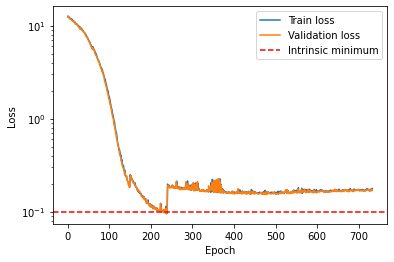

In [25]:
NDE_theta.plot_loss(0.1)
plt.yscale('log')

In [26]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

# NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
# NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 238
Best train loss: 0.10536247491836548
Best vali loss: 0.09424303472042084


In [24]:
from popsed.nde import transform_nmf_params_given_z, inverse_transform_nmf_params_given_z

In [19]:
samples = NDE_theta.sample(4000)

0 4000
>40 0


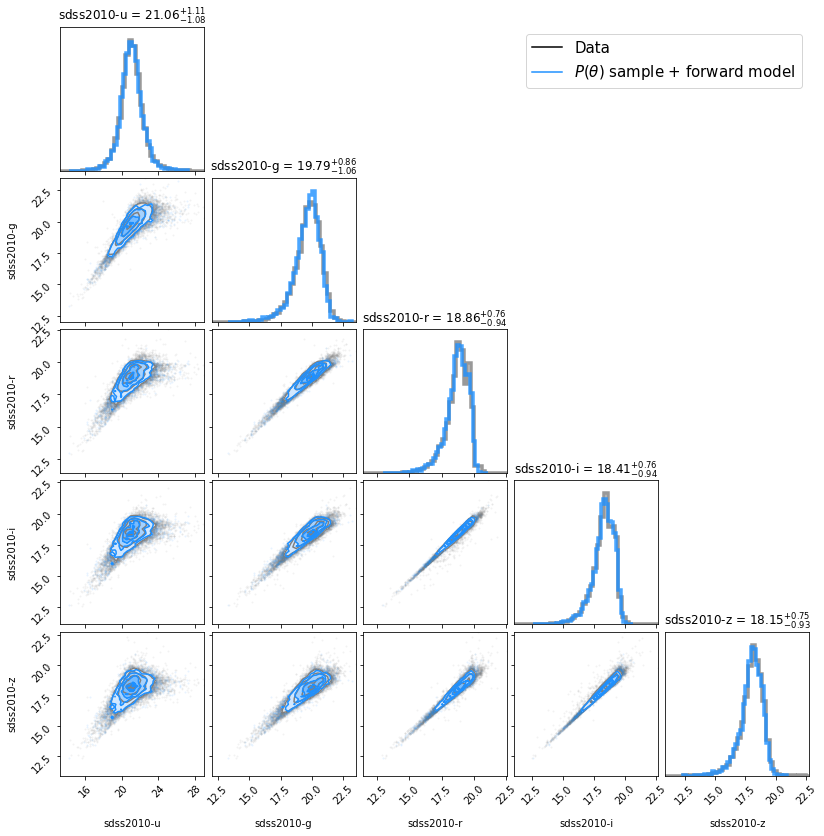

In [20]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir, SNR=1
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [21]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

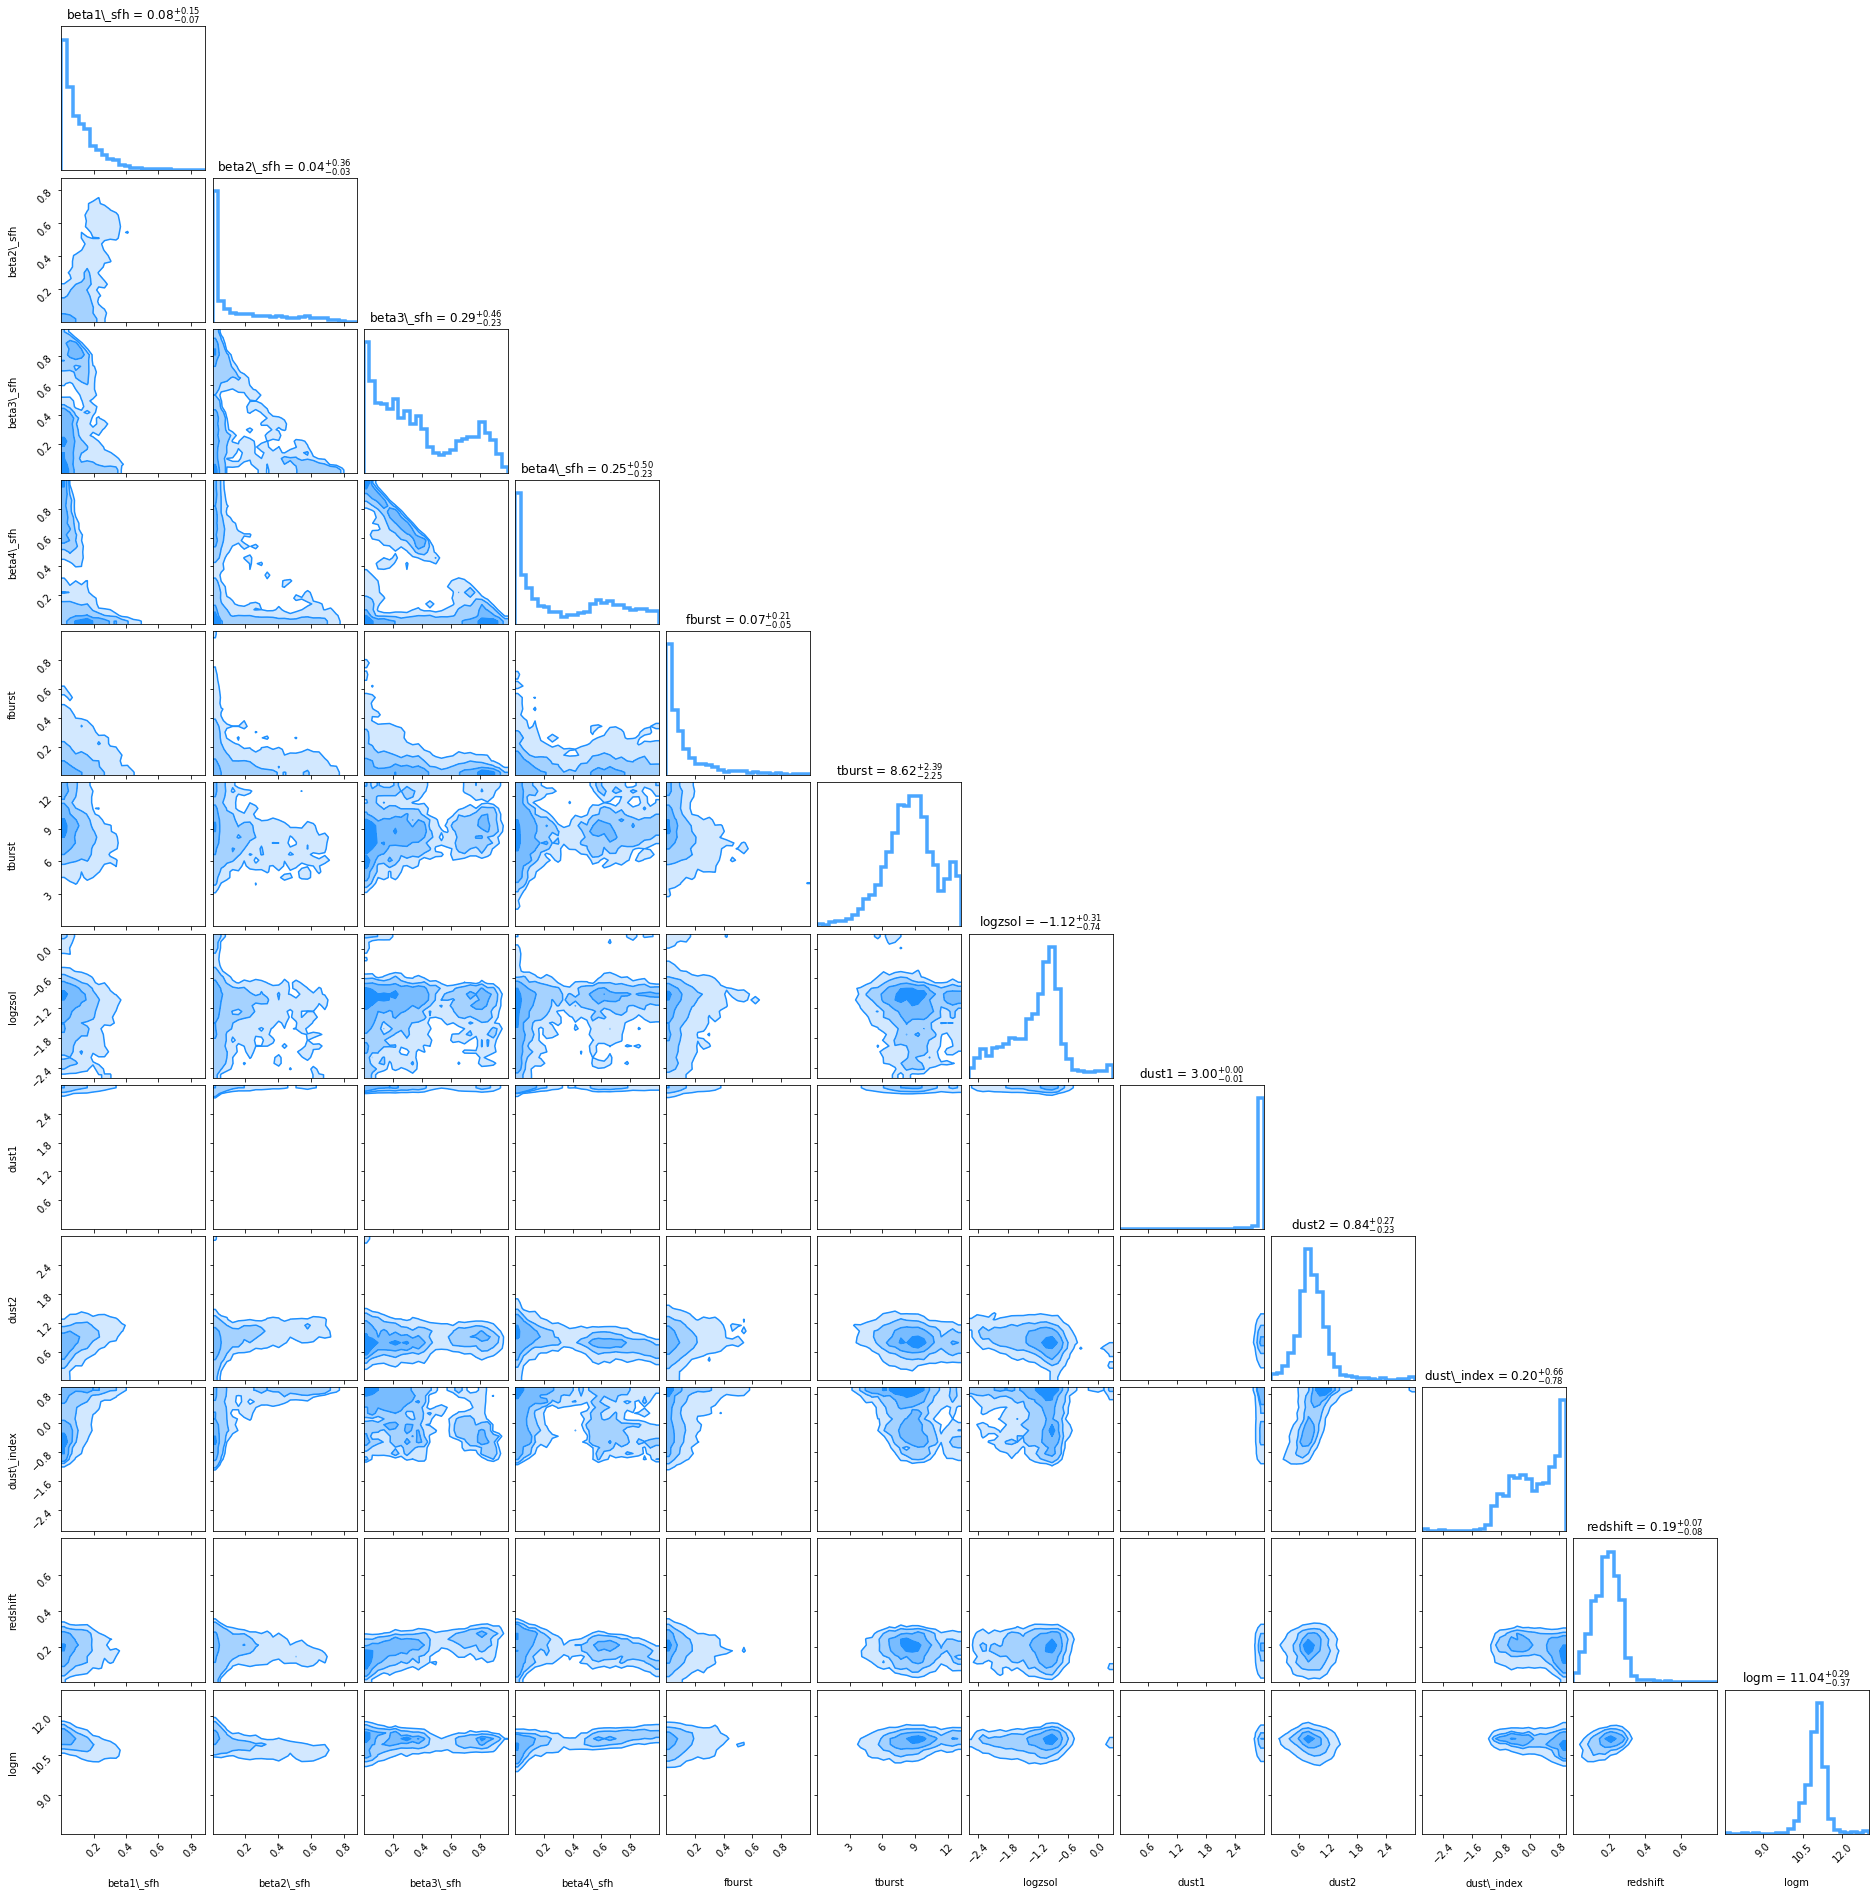

In [22]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [23]:
z_mass_met = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')

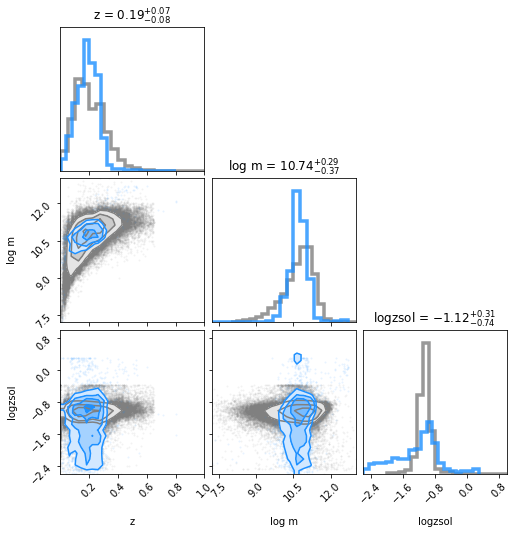

In [24]:
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=20,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                       range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:] - 0.3, _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=20,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

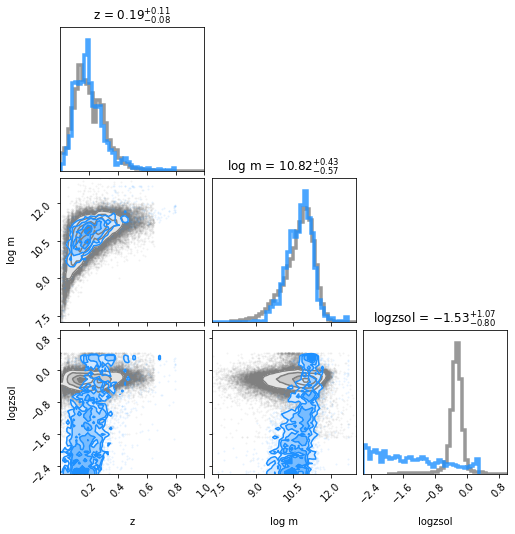

In [44]:
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                       range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:] - 0.3, _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [64]:
from popsed.models import NMF_ZH
model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [63]:
params = np.hstack([_samples[:, -1:], _samples[:, :-1]])

In [69]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))
zmw = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [78]:
redshift = params[:, -1]
logmstar = params[:, 0]
logzsol = np.log10(zmw / 0.019)

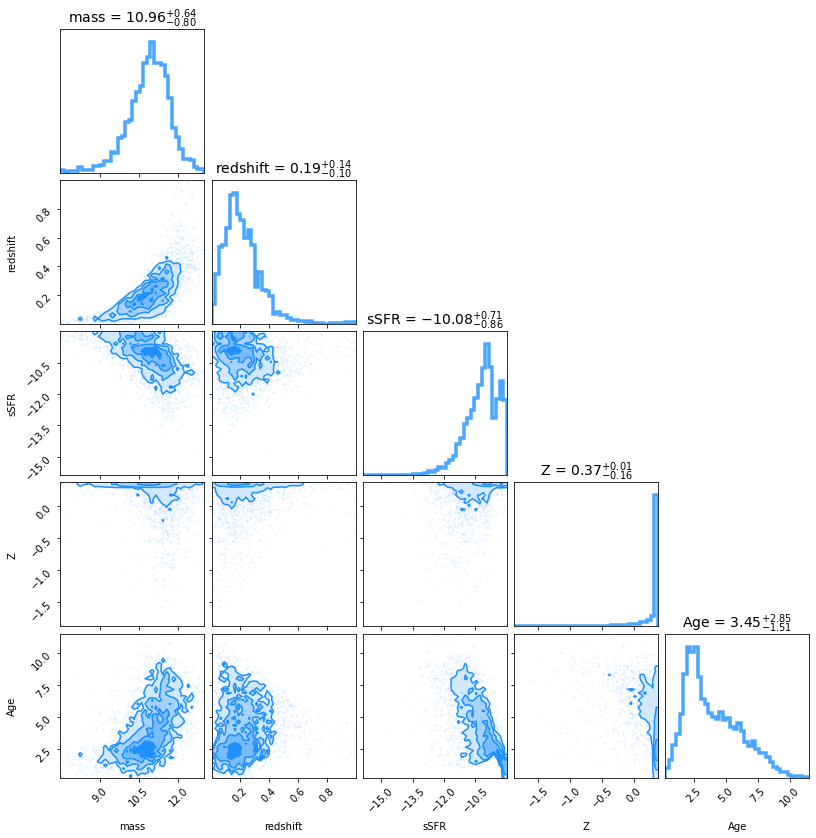

In [79]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['mass','redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [31]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

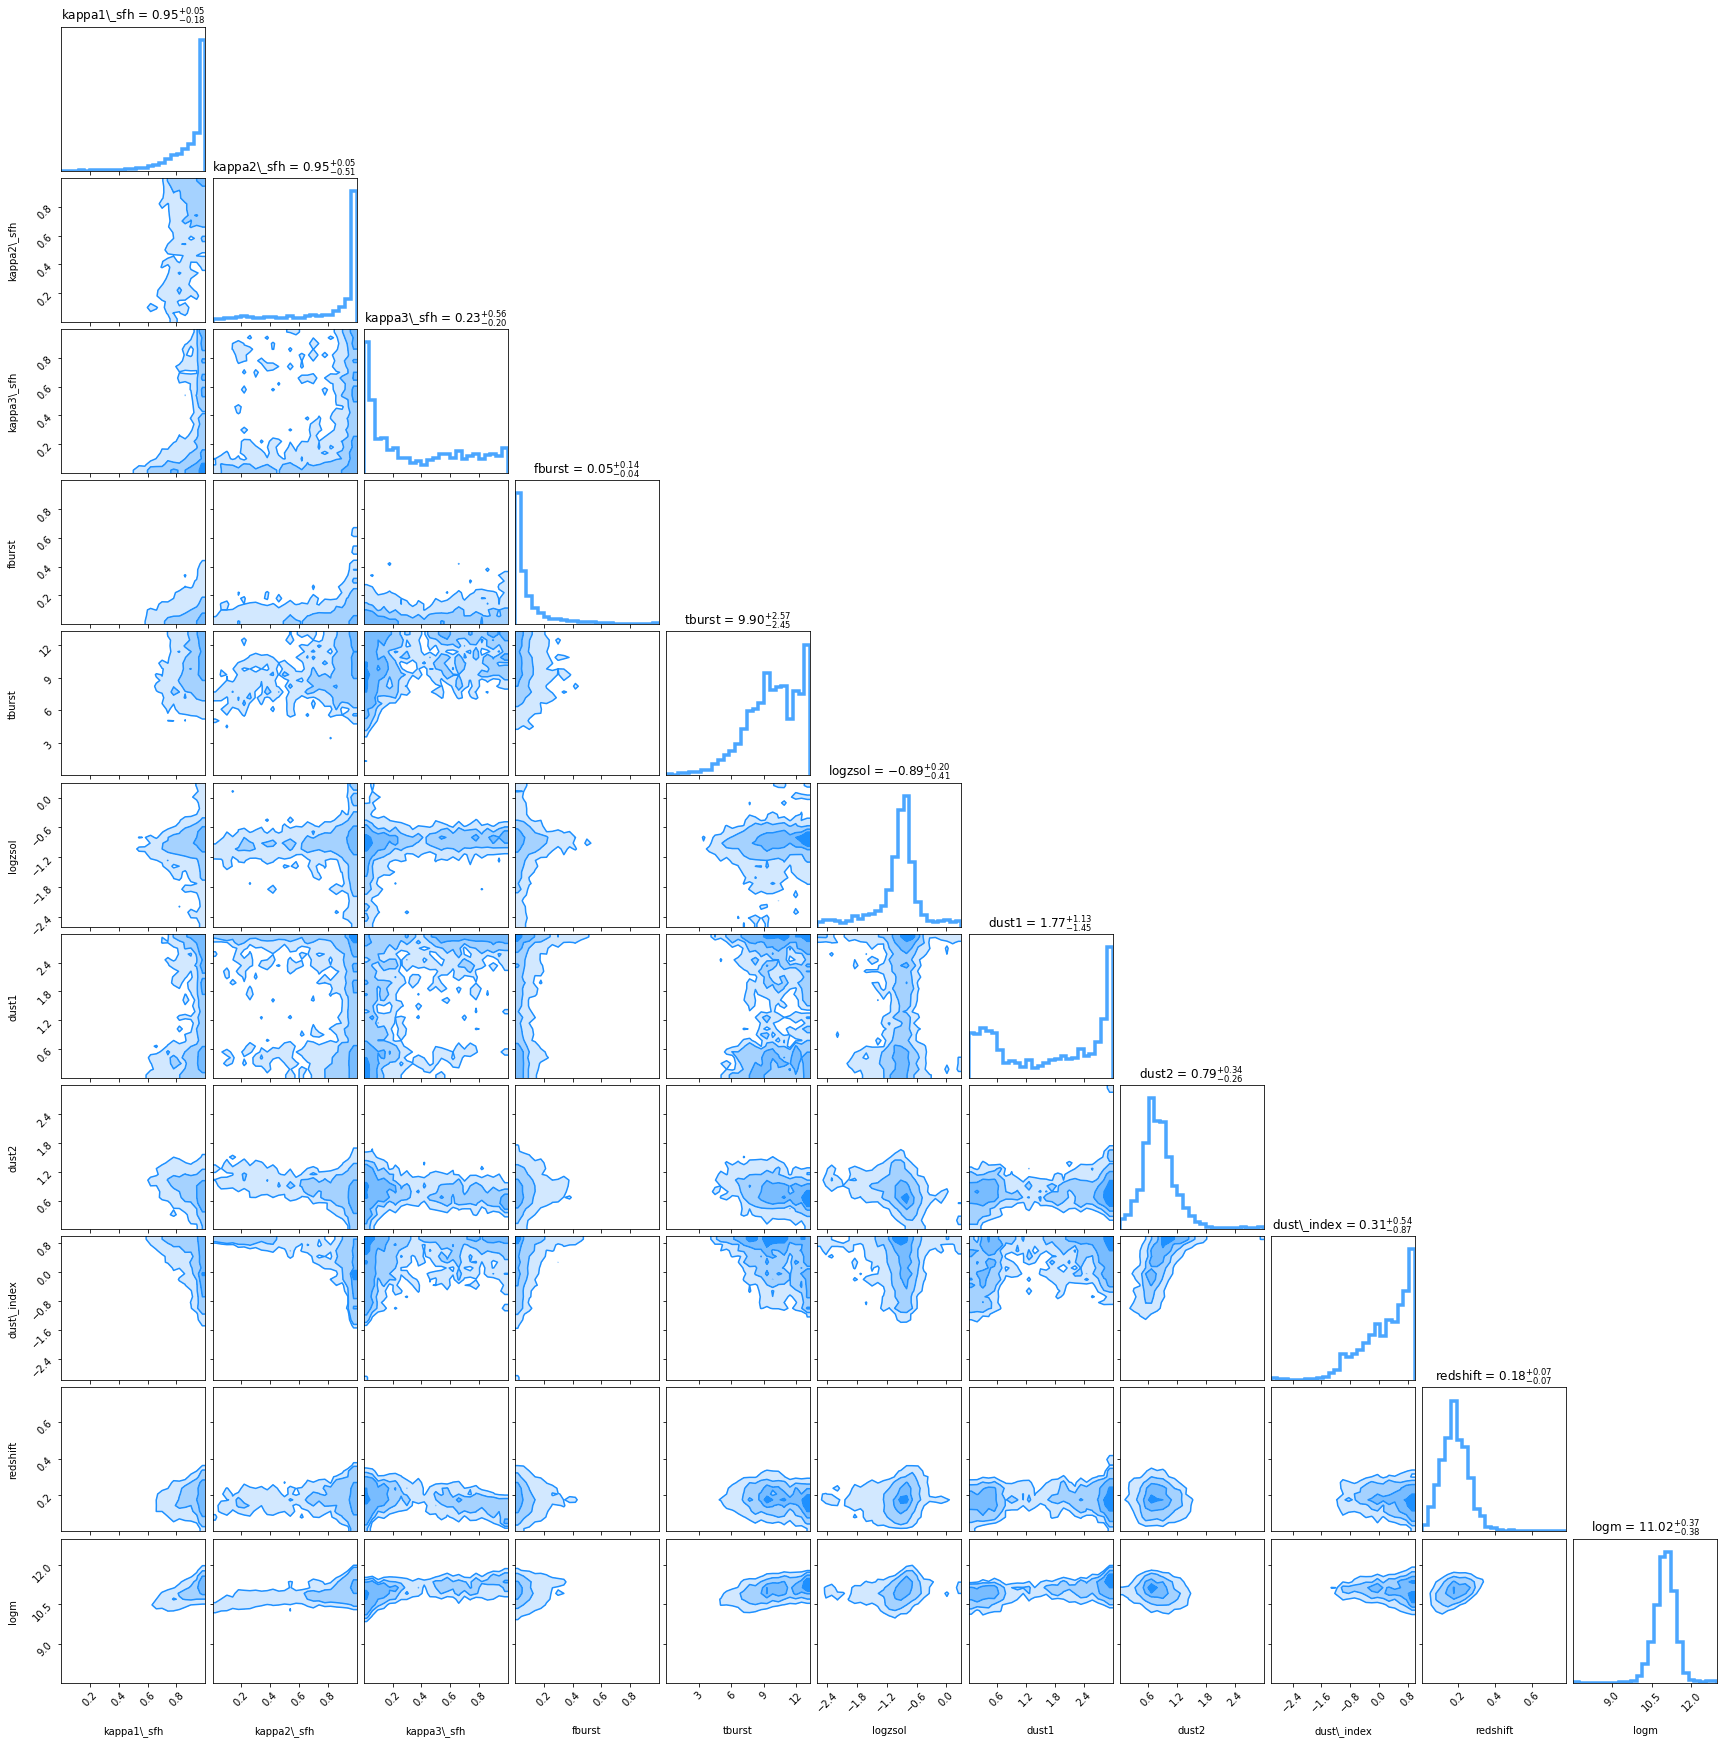

In [32]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))